<!DOCTYPE html> <html> <head> <style> .section-title {background-color: #2ecc71; color:white; border-radius: 15px;} </style> </head> <body> 
# <center> <div class="section-title">Libraries</div> <center> </body> </html>

In [2]:
import pandas as pd
import time
from googleapiclient.discovery import build
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from thefuzz import fuzz, process
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline
import numpy as np
import torch
import nltk
import re

<!DOCTYPE html> <html> <head> <style> .section-title {background-color: #2ecc71; color:white; border-radius: 15px;} </style> </head> <body> 
# <center> <div class="section-title">Introduction</div> <center> </body> </html>

The European Super League (ESL) is a proposed season-long football competition for clubs in Europe. It was proposed on April 18, 2021 by a group of 12 of the biggest and most traditional European teams from England, Italy and Spain, including Real Madrid, Manchester United and Juventus.  

The plans for the European Super League caused a great stir, as it would significantly change European football. On December 21, 2023, the European Court of Justice strengthened the plan for a possible Super League. 

In this analysis, I would like to investigate how the fan community views the possible creation of the European Super League and whether this opinion has changed over the last few years.


<!DOCTYPE html> <html> <head> <style> .section-title {background-color: #2ecc71; color:white; border-radius: 15px;} </style> </head> <body> 
# <center> <div class="section-title">Data acquisition</div> <center> </body> </html>

In order to obtain comprehensive fan opinions, comments from six videos were collected via the YouTube API. These videos come from various sports news channels and cover the topic of the European Super League. The selection includes videos from April 2021, when the Super League was first introduced, and December 2023, after the European Court of Justice ruling. 

o	European Super League – Sky Sports News (19.04.2021) ->  https://www.youtube.com/watch?v=Tk3VqsqeA9  
o	European Super League – ESPN FC (21.12.2023) -> https://www.youtube.com/watch?v=65FrT_NHRF0&t=29s  
o	Absolutely disgusting, bang out of order, ESL – BBC Sport (19.04.2021) -> https://www.youtube.com/watch?v=m0RM1PN-yAk  
o	How have UEFA responded – Sky Sports News (21.12.2023) -> https://www.youtube.com/watch?v=hRKgzn_128g  
o	European Court Rules – CBS Sports Golazo (21.12.2023) ->  https://www.youtube.com/watch?v=ypdvmYUUOBQ  
o	I am absolutely disgusted, ESL proposals -  Sky Sports Premier League (18.04.2021) -> https://www.youtube.com/watch?v=GP05EDm9EB8


In [1]:
def get_video_comments(api_key, video_ids, max_results=100):
    comments_list = []

    for video_id in video_ids:
        youtube = build('youtube', 'v3', developerKey=api_key)
        next_page_token = None

        while True:
            comments = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                textFormat='plainText',
                maxResults=max_results,
                pageToken=next_page_token
            ).execute()

            for comment in comments['items']:
                comment_data = {
                    'author': comment['snippet']['topLevelComment']['snippet']['authorDisplayName'].replace('@', ''),
                    'published': comment['snippet']['topLevelComment']['snippet']['publishedAt'],
                    'like_count': comment['snippet']['topLevelComment']['snippet']['likeCount'],
                    'comment': comment['snippet']['topLevelComment']['snippet']['textDisplay'],
                    
                }
                comments_list.append(comment_data)

            next_page_token = comments.get('nextPageToken')

            if not next_page_token:
                break

            time.sleep(2)

    df_all_comments = pd.DataFrame(comments_list)
    return df_all_comments


In [4]:
youtube_api_key = '***video_ids_list = ['Tk3VqsqeA9c', '65FrT_NHRF0', 'm0RM1PN-yAk', 'ypdvmYUUOBQ', 'hRKgzn_128g']

df_1 = get_video_comments(youtube_api_key, video_ids_list)

In [6]:
df_2 = get_video_comments(youtube_api_key, ['GP05EDm9EB8'])

df = pd.concat([df_1, df_2], ignore_index=True)

In [7]:
df.to_csv('youtube_superleague_comments.csv' , index=False, escapechar='\\')

In [3]:
superleague_comments = pd.read_csv('youtube_superleague_comments.csv')

display(superleague_comments.shape)
display(superleague_comments.head())

(18859, 4)

,author,published,like_count,comment
0,MsGangster107,2023-12-23T08:29:48Z,0,The biggest crap is when clubs start a super l...
1,bobsmith3291,2023-11-25T03:19:18Z,0,The cheek of Man City and rotor ham to think t...
2,devongarvie6261,2023-07-21T11:50:56Z,0,"If they had gone ahead with this, I would have..."
3,rednaskela4830,2023-06-20T12:10:44Z,0,The ignorant American owners infuriates me mor...
4,ymg8057,2022-12-07T18:27:24Z,0,When does it start? I thought it was supposed ...


In order to identify the main topics in the comments and obtain an initial overview, a word cloud and topic modeling were applied using Latent Dirichlet Allocation (LDA). The Word Cloud highlights keywords such as “club”, “fan”, “football” and “money”, while the LDA model shows topics such as “club(s)”, “football”, “league” and “Gary Neville”.

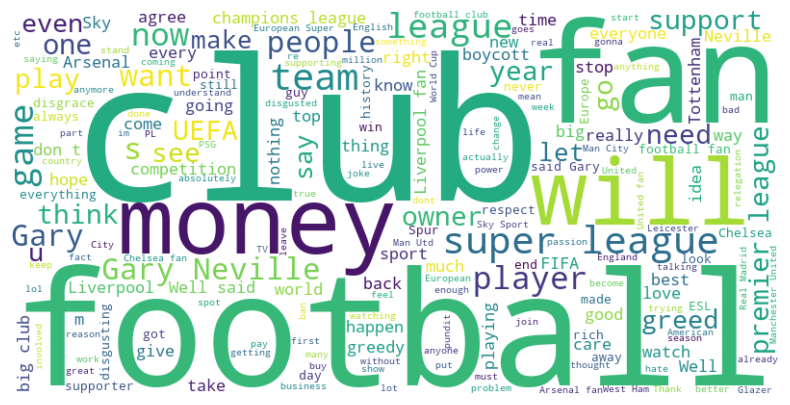

In [4]:
all_comments = superleague_comments['comment'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
comments = superleague_comments['comment']

# Bag-of-Words-Darstellung mit NLTK-Stopwörtern
vectorizer = CountVectorizer(stop_words=('english'))
X = vectorizer.fit_transform(comments)

# Latent Dirichlet Allocation (LDA) Modell mit 10 Topics
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Ausgabe der Top Wörter für jedes Thema
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: league, tottenham, clubs, super, arsenal, champions, bayern, teams, spurs, big
Topic #2: money, clubs, club, football, years, game, man, just, city, owners
Topic #3: football, fans, fan, club, disgrace, money, game, arsenal, going, united
Topic #4: league, super, watch, don, just, european, clubs, premier, fans, champions
Topic #5: gary, neville, fans, said, agree, clubs, football, absolutely, owners, don
Topic #6: sky, sports, rights, tv, watch, like, years, bt, agree, football
Topic #7: league, clubs, teams, players, play, money, want, premier, big, let
Topic #8: football, money, uefa, fifa, clubs, world, greed, just, people, fans
Topic #9: fan, gary, liverpool, neville, united, respect, man, club, chelsea, support
Topic #10: points, clubs, people, football, like, money, disgusting, deduct, big, teams


<!DOCTYPE html> <html> <head> <style> .section-title {background-color: #2ecc71; color:white; border-radius: 15px;} </style> </head> <body> 
# <center> <div class="section-title">Preprocessing</div> <center> </body> </html>

### Step 1: Filtering

After the initial identification of topics and a manual review of the first comments, it became apparent that the statements in the comments vary significantly. Although the core of the discussion focuses on European soccer and the European Super League (ESL), some comments only mention these topics indirectly.  

Comments of this kind bias the results and in order to focus exclusively on analyzing the possible foundation of the ESL, two specific functions were created to filter the most relevant comments. 


In [6]:
def filter_super_league_comments(comment):
    relevant_entities = ["super league", "superleague",  "sl", "super", "league", "european super league", 
                       "european league", "european",  "european",  "esl"]
    
    # Überprüft die Ähnlichkeit des Kommentars mit den relevanten Entitäten
    similarity_scores = [fuzz.partial_ratio(comment, entity) for entity in relevant_entities]
    
    # Wenn die höchste Ähnlichkeit über einem Schwellenwert liegt, betrachtet den Kommentar als relevant
    return max(similarity_scores) > 90

In [7]:
def filter_irrelevant_comments(comment):
    irrelevant_entities = ["guillem", "balague", "gary", "neville", "jamie", "carragher", "florentino", "perez", "joan", "laporta",
                       "brexit", "gianni", "infantino", "fifa", "uefa", "aleksander", "ceferin", "sky", "sky sports", "espn", 
                       "espn fc" "cbs", "cbs sports" "bbc"]
    
    # Überprüft die Ähnlichkeit des Kommentars mit den irrelevanten Entitäten
    similarity_scores = [fuzz.partial_ratio(comment, entity) for entity in irrelevant_entities]
    
    # Wenn die höchste Ähnlichkeit über einem Schwellenwert liegt, betrachtet den Kommentar als irrelevant
    return max(similarity_scores) > 90

In [8]:
superleague_comments['super_league_comments'] = tqdm(superleague_comments['comment'].apply(filter_super_league_comments), desc="Filtering Super League comments")
superleague_comments['irrelevant_comments'] = tqdm(superleague_comments['comment'].apply(filter_irrelevant_comments), desc="Filtering irrelevant comments")

sl_filtered = superleague_comments[(superleague_comments['super_league_comments']) & (~superleague_comments['irrelevant_comments'])]


Filtering irrelevant comments: 100%|██████████| 18859/18859 [00:00<00:00, 1569483.11it/s]


In [9]:
display(sl_filtered.shape)
display(sl_filtered.head())

(3724, 6)

,author,published,like_count,comment,super_league_comments,irrelevant_comments
0,MsGangster107,2023-12-23T08:29:48Z,0,The biggest crap is when clubs start a super l...,True,False
4,ymg8057,2022-12-07T18:27:24Z,0,When does it start? I thought it was supposed ...,True,False
10,fredericcjm7,2021-09-17T12:48:51Z,1,Rip super league you will not be missed 🤮🤢,True,False
11,FreezePlayz1,2021-08-16T15:19:21Z,0,Why so many dislikes,True,False
12,jaysoncooley9602,2021-07-28T19:46:50Z,0,Premier league fa cup carbon Cup champions lea...,True,False


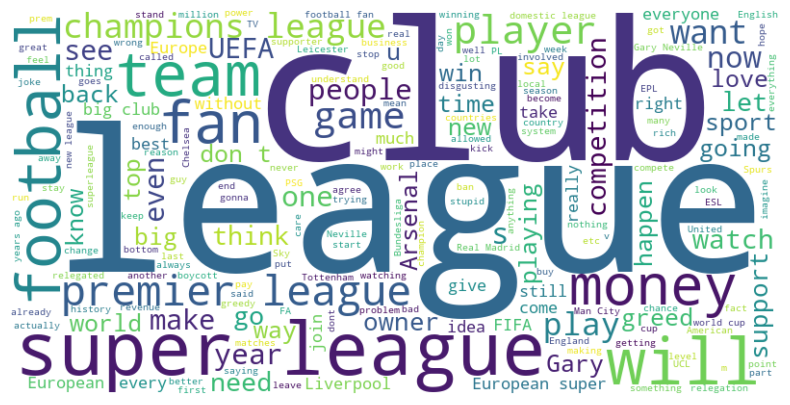

In [12]:
filtered_comments = sl_filtered['comment'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The repeated display of the Word Cloud using the filtered DataFrame illustrates the successful selection of relevant comments, with terms such as “super league” clearly coming to the front and names such as Gary Neville no longer appearing.

### Step 2: Cleaning

Two runs were carried out to test the influence of cleaning on the model evaluation. It was observed that lemmatization and the removal of stop words strongly biased the sentiment. For this reason, these steps were commented out and only a light cleaning was carried out

In [13]:
def clean_text(text):

    # Entfernt Sonderzeichen, außer Ausrufezeichen, Fragezeichen und Zahlen
    cleaned_text = re.sub(r'[^A-Za-z\s!?]', '', text)

    # Entfernung von Unicode-Zeichen, Apostrophen und Wörtern mit Zahlen
    cleaned_text = re.sub(r'[^\x00-\x7F]+|\'\w+|\w*\d+\w*', ' ', cleaned_text)

    # Reduzierung von aufeinanderfolgenden Leerzeichen
    cleaned_text = re.sub(r'\s{2,}', ' ', cleaned_text)

    return cleaned_text

In [14]:
def tokenize_and_remove_stopwords(text):
    # Tokenisierung
    tokens = word_tokenize(text.lower())
    
    # Stoppwortentfernung
    #stop_words = set(stopwords.words('english'))
    #tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [22]:
"""
def apply_lemmatization(tokens):
    # Lemmatisierung
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens
""";

In [15]:
def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokens = tokenize_and_remove_stopwords(cleaned_text)
    #lemmatized_tokens = apply_lemmatization(tokens)
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


In [16]:
sl_filtered.loc[:, 'processed_comment'] = sl_filtered['comment'].apply(preprocess_text)

C:\Users\lionm\AppData\Local\Temp\ipykernel_4388\194338434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sl_filtered.loc[:, 'processed_comment'] = sl_filtered['comment'].apply(preprocess_text)


In [17]:
sl_filtered = sl_filtered.drop(columns=['super_league_comments', 'irrelevant_comments'])

display(sl_filtered.shape)
display(sl_filtered.head())

(3724, 5)

,author,published,like_count,comment,processed_comment
0,MsGangster107,2023-12-23T08:29:48Z,0,The biggest crap is when clubs start a super l...,the biggest crap is when clubs start a super l...
4,ymg8057,2022-12-07T18:27:24Z,0,When does it start? I thought it was supposed ...,when does it start ? i thought it was supposed...
10,fredericcjm7,2021-09-17T12:48:51Z,1,Rip super league you will not be missed 🤮🤢,rip super league you will not be missed
11,FreezePlayz1,2021-08-16T15:19:21Z,0,Why so many dislikes,why so many dislikes
12,jaysoncooley9602,2021-07-28T19:46:50Z,0,Premier league fa cup carbon Cup champions lea...,premier league fa cup carbon cup champions lea...


<!DOCTYPE html> <html> <head> <style> .section-title {background-color: #2ecc71; color:white; border-radius: 15px;} </style> </head> <body> 
# <center> <div class="section-title">Analyse</div> <center> </body> </html>

The sentiments of the comments were determined using the “cardiffnlp/twitter-roberta-base-sentiment” model. This roBERTa model, trained on 58 million tweets, provides a precise distinction between negative, neutral and positive sentiment. 

In [18]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
pipe = pipeline(task = "text-classification", model = MODEL)

In [19]:
results = []

for text in tqdm(sl_filtered['processed_comment']):
    
    # Klassifikation mit dem Modell
    with torch.no_grad():
        tokens = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True)
        outputs = model(tokens)

    # Softmax auf den Output anwenden
    scores = torch.nn.functional.softmax(outputs.logits[0], dim=0).numpy()

    # Scores zu einem Dictionary hinzufügen
    scores_dict = {
        'negativ': scores[0],
        'neutral': scores[1],
        'positiv': scores[2],
    }
    results.append(scores_dict)


100%|██████████| 3724/3724 [17:07<00:00,  3.62it/s]


In [20]:
# Ergebnisse zum DataFrame hinzufügen
df_scores = pd.DataFrame(results)
sl_filtered = pd.concat([sl_filtered.reset_index(drop=True), df_scores], axis=1)

In [21]:
display(sl_filtered.shape)
display(sl_filtered.head())

(3724, 8)

,author,published,like_count,comment,processed_comment,negativ,neutral,positiv
0,MsGangster107,2023-12-23T08:29:48Z,0,The biggest crap is when clubs start a super l...,the biggest crap is when clubs start a super l...,0.898266,0.094501,0.007234
1,ymg8057,2022-12-07T18:27:24Z,0,When does it start? I thought it was supposed ...,when does it start ? i thought it was supposed...,0.509378,0.365757,0.124864
2,fredericcjm7,2021-09-17T12:48:51Z,1,Rip super league you will not be missed 🤮🤢,rip super league you will not be missed,0.041539,0.234862,0.723599
3,FreezePlayz1,2021-08-16T15:19:21Z,0,Why so many dislikes,why so many dislikes,0.834310,0.158053,0.007637
4,jaysoncooley9602,2021-07-28T19:46:50Z,0,Premier league fa cup carbon Cup champions lea...,premier league fa cup carbon cup champions lea...,0.954564,0.040883,0.004553


### Sentiment Super League Plot

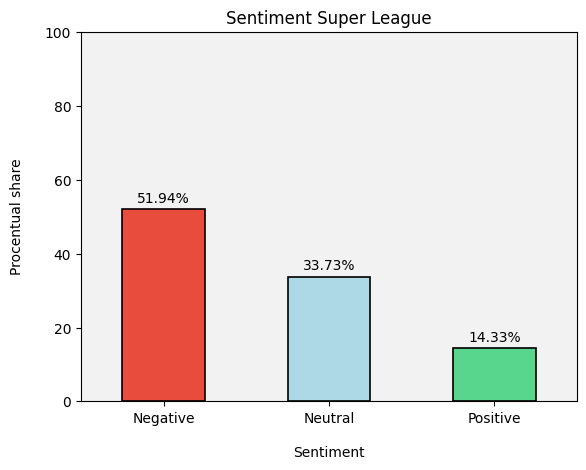

In [22]:
# Berechnet den prozentualen Anteil für jede Kategorie
percentages = sl_filtered[['negativ', 'neutral', 'positiv']] * 100

colors = ['#E74C3C', '#ADD8E6', '#58D68D']

# Plot
labels = ['Negative', 'Neutral', 'Positive']
ax = percentages.mean().plot(kind='bar', color=colors, edgecolor='black', linewidth=1.2)
ax.set_xticklabels(labels, rotation=0)
ax.set_facecolor('#F2F2F2')

# Fügt prozentualen Anteil auf die Balken ein
for i, value in enumerate(percentages.mean()):
    ax.text(i, value + 2, f'{value:.2f}%', ha='center')

plt.ylim(0, 100)
plt.xlabel('Sentiment', labelpad=15) 
plt.ylabel('Procentual share', labelpad=15)
plt.title('Sentiment Super League')
plt.show()


### Sentiment over time

In [23]:
sl_filtered['published'] = pd.to_datetime(sl_filtered['published'])

# Daten nach Jahr
sl_filtered_2021 = sl_filtered[sl_filtered['published'].dt.year == 2021]
sl_filtered_2022 = sl_filtered[sl_filtered['published'].dt.year == 2022]
sl_filtered_2023 = sl_filtered[sl_filtered['published'].dt.year == 2023]

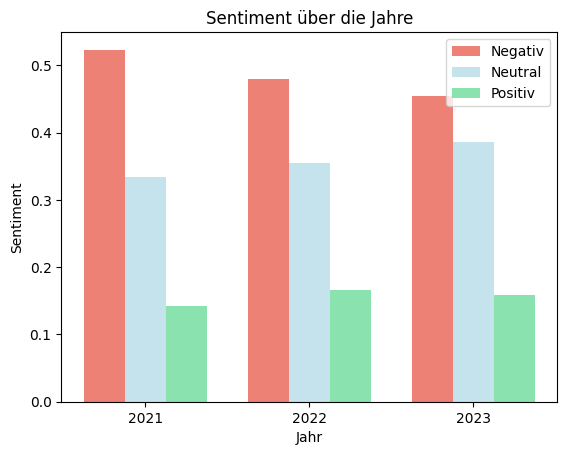

In [27]:
years = ['2021', '2022', '2023']
sentiments_avg_neg = [sl_filtered_2021['negativ'].mean(), sl_filtered_2022['negativ'].mean(), sl_filtered_2023['negativ'].mean()]
sentiments_avg_neu = [sl_filtered_2021['neutral'].mean(), sl_filtered_2022['neutral'].mean(), sl_filtered_2023['neutral'].mean()]
sentiments_avg_pos = [sl_filtered_2021['positiv'].mean(), sl_filtered_2022['positiv'].mean(), sl_filtered_2023['positiv'].mean()]

bar_width = 0.25  

# Verschiebt die Balken für ein besseres Layout
bar_positions_neg = [0.75, 1.75, 2.75]
bar_positions_neu = [1, 2, 3]
bar_positions_pos = [1.25, 2.25, 3.25]

plt.bar(bar_positions_neg, sentiments_avg_neg, width=bar_width, label='Negativ', color='#E74C3C', alpha=0.7)
plt.bar(bar_positions_neu, sentiments_avg_neu, width=bar_width, label='Neutral', color='#ADD8E6', alpha=0.7)
plt.bar(bar_positions_pos, sentiments_avg_pos, width=bar_width, label='Positiv', color='#58D68D', alpha=0.7)

plt.xlabel('Jahr')
plt.ylabel('Sentiment')
plt.title('Sentiment über die Jahre')
plt.xticks(bar_positions_neu, years)  
plt.legend()
plt.show()

### Sample comments to check model evaluation

In [26]:
# Beispiele für negative Kommentare
negative_examples = sl_filtered[sl_filtered['negativ'] > 0.7]['comment'].head(5).tolist()
print("Negative Beispiele:")
for example in negative_examples:
    print(f"- {example}")
print()

# Beispiele für neutrale Kommentare
neutral_examples = sl_filtered[sl_filtered['neutral'] > 0.7]['comment'].head(5).tolist()
print("Neutrale Beispiele:")
for example in neutral_examples:
    print(f"- {example}")
print()

# Beispiele für positive Kommentare
positive_examples = sl_filtered[sl_filtered['positiv'] > 0.7]['comment'].head(5).tolist()
print("Positive Beispiele:")
for example in positive_examples:
    print(f"- {example}")


Negative Beispiele:
- The biggest crap is when clubs start a super league... In the third case, some club will steal a large amount of money. You know what I want to tell you (stealing money for your own interests) Clubs should compete and not deal with other things. Here nui more in the game just the game as such. The Super League is the brainchild of certain lobbies who want to get rich. The game of football itself will no longer make sense.
- Why so many dislikes
- Premier league fa cup carbon Cup champions league Europa league have all run they course and don't matter in what other jackass fans or other ex players say cause ye all a pack of stupid retarded jackasses
- And what exactly makes Tottenham super? What late achievement does qualify them to be part of the 12? This whole idea of a new super league is just a bad joke...
- Kettle calling the pot black for me. Euro super league and Sky, just 2 greedy pigs at the one trough. The hypocrisy knows no limits. 👎

Neutrale Beispiele:

<!DOCTYPE html> <html> <head> <style> .section-title {background-color: #2ecc71; color:white; border-radius: 15px;} </style> </head> <body> 
# <center> <div class="section-title">Conclusion</div> <center> </body> </html>

The analysis of the comments revealed interesting insights into opinions on the European Super League (ESL). The majority of comments - 52% - expressed negative sentiment, while 34% were rated as neutral and 14% as positive.  

In particular, the trend over time shows significant changes in the perception of the Super League. The proportion of negative comments is decreasing, while neutral and positive comments are gradually increasing. 


### Limitations

- The review of the sample comments for the various categories (negative, neutral, positive) reveals that the model delivers solid results. Nevertheless, there are certain limits to the accuracy of the evaluation. One example is the evaluation of the sentence: “Rip Super League, you will not be missed 🤮🤢”, which was falsely evaluated as positive.


### Refernces

-	https://developers.google.com/youtube/v3/docs/commentThreads/list?hl=de&apix_params=%7B%22part%22%3A%5B%22id%2C%20snippet%22%5D%2C%22videoId%22%3A%22Tk3VqsqeA9c%22%7D
-	https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
